In [3]:
import json
from datetime import datetime
import pandas as pd

# Define historical holdings and released PL
historical_holdings = [
    {
        "ticker": "AAPL",
        "quantity": 10,
        "startDate": "02-04-2024",
        "endDate": "04-08-2024",
        "averagePrice": 169.0
    },
    {
        "ticker": "AAPL",
        "quantity": 15,
        "startDate": "05-08-2024",
        "endDate": "10-11-2024",
        "averagePrice": 182.33
    },
    {
        "ticker": "NET",
        "quantity": 5,
        "startDate": "19-11-2024",
        "endDate": None,
        "averagePrice": 95
    },
]

released_pl = [
    {
        "ticker": "AAPL",
        "date": "11-11-2024",
        "amount": 3367.5,
    }
]

with open('market_data_aapl.json') as file:
    market_data_aapl = json.load(file)

with open('market_data_net.json') as file:
    market_data_net = json.load(file)

prices_aapl = [
    {"date": datetime.fromisoformat(item["date"]).strftime("%d-%m-%Y"), "close": item["close"]}
    for item in market_data_aapl.get("data", [])
]

prices_net = [
    {"date": datetime.fromisoformat(item["date"]).strftime("%d-%m-%Y"), "close": item["close"]}
    for item in market_data_net.get("data", [])
]

market_data = {
    "AAPL": prices_aapl,
    "NET": prices_net
}







In [5]:
# Prepare market data as a DataFrame
market_data_flat = []
for ticker, prices in market_data.items():
    for record in prices:
        market_data_flat.append({"ticker": ticker, "date": record["date"], "close": record["close"]})

market_df = pd.DataFrame(market_data_flat)
market_df["date"] = pd.to_datetime(market_df["date"], format="%d-%m-%Y")

# Create a date range based on market data
start_date = market_df["date"].min()
end_date = market_df["date"].max()
all_dates = pd.date_range(start=start_date, end=end_date)

# Create a base DataFrame with all dates
result_df = pd.DataFrame({"date": all_dates})
result_df["released_pl"] = 0.0

# Add released P/L
for pl in released_pl:
    pl_date = datetime.strptime(pl["date"], "%d-%m-%Y")
    result_df.loc[result_df["date"] >= pl_date, "released_pl"] += pl["amount"]

# Compute portfolio value and market value
portfolio_value_list = []
market_value_list = []

for _, row in result_df.iterrows():
    current_date = row["date"]
    portfolio_value = row["released_pl"]
    market_value = row["released_pl"]

    for holding in historical_holdings:
        start_date = datetime.strptime(holding["startDate"], "%d-%m-%Y")
        end_date = (
            datetime.strptime(holding["endDate"], "%d-%m-%Y")
            if holding["endDate"] else None
        )

        if start_date <= current_date and (end_date is None or current_date <= end_date):
            quantity = holding["quantity"]
            avg_price = holding["averagePrice"]

            # Add to portfolio value
            portfolio_value += quantity * avg_price

            # Market value calculation
            market_price = market_df.loc[
                (market_df["ticker"] == holding["ticker"]) & (market_df["date"] == current_date), "close"
            ]
            if not market_price.empty:
                market_value += quantity * market_price.values[0]

    portfolio_value_list.append(portfolio_value)
    market_value_list.append(market_value)

# Add values to the DataFrame
result_df["portfolio_value"] = portfolio_value_list
result_df["market_value"] = market_value_list

# Display the result
print(result_df[["date", "portfolio_value", "market_value"]])

          date  portfolio_value  market_value
0   2023-11-24              0.0          0.00
1   2023-11-25              0.0          0.00
2   2023-11-26              0.0          0.00
3   2023-11-27              0.0          0.00
4   2023-11-28              0.0          0.00
..         ...              ...           ...
360 2024-11-18           3367.5       3367.50
361 2024-11-19           3842.5       3849.35
362 2024-11-20           3842.5       3849.85
363 2024-11-21           3842.5       3888.70
364 2024-11-22           3842.5       3888.65

[365 rows x 3 columns]


Traceback (most recent call last):
  File "/Users/alex/Applications/PyCharm.app/Contents/plugins/python-ce/helpers/pydev/pydevd.py", line 1165, in cancel_async_evaluation
    all_threads = threadingEnumerate()
  File "/opt/homebrew/Cellar/python@3.13/3.13.0_1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/threading.py", line 1477, in enumerate
    def enumerate():
    
KeyboardInterrupt


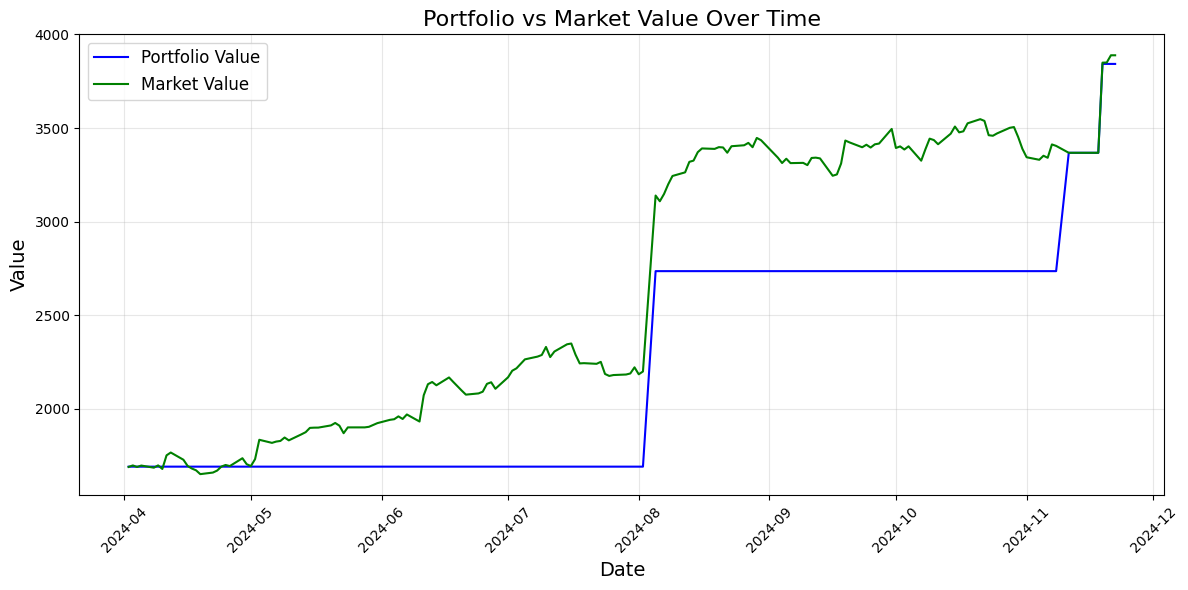

In [11]:
import matplotlib.pyplot as plt

# Filter out rows where market_value is zero
filtered_df = result_df[result_df["market_value"] != 0]

# Plot portfolio value and market value
plt.figure(figsize=(12, 6))
plt.plot(filtered_df["date"], filtered_df["portfolio_value"], label="Portfolio Value", color="blue")
plt.plot(filtered_df["date"], filtered_df["market_value"], label="Market Value", color="green")

# Formatting the plot
plt.title("Portfolio vs Market Value Over Time", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Value", fontsize=14)
plt.xticks(rotation=45)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()

# Show the plot
plt.show()